# Statistical Report

In [1]:
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlite3 import connect

sns.set_theme(style="whitegrid")

conn = connect(":memory:")
now_str = datetime.now().strftime("%Y%m%d%H%M%S")

## Load Analyzed Data

In [2]:
def query_df_with_sql(sql, df, table_name="audio_features", conn=conn):
    df.to_sql(name=table_name, con=conn, if_exists="replace")
    return pd.read_sql(sql, conn)

In [3]:
loaders_by_format = {
    "csv": pd.read_csv,
    "xlsx": pd.read_excel,
    # "db": pd.read_sql,
    "parquet": pd.read_parquet,
    "npy": lambda x: pd.DataFrame(list(np.load(x, allow_pickle=True))),
}


def load_data(filepath):
    extension = Path(filepath).name.split(".")[1]
    return loaders_by_format[extension](filepath)


df = load_data("../data/processed/20250212032022_audio_features.npy")

In [4]:
df.columns

Index(['extracted_time_utc', 'filepath', 'duration', 'sample_rate',
       'num_channels', 'md5', 'bit_rate', 'codec', 'tempocnn_bpm',
       'key_temperley_predict', 'key_temperley_probability',
       'key_krumhansl_predict', 'key_krumhansl_probability',
       'key_edma_predict', 'key_edma_probability',
       'loudness_ebur128_integrated_lufs', 'loudness_ebur128_range_lu',
       'emomusic_valence', 'emomusic_arousal', 'musicnn_embeddings_mean',
       'style_genre_discogs400', 'style_genre_discogs400_probability',
       'vggish_voice', 'vggish_instrumental', 'effnet_discogs_danceable',
       'effnet_discogs_not_danceable', 'discogs_embeddings_mean'],
      dtype='object')

In [5]:
df.head()

,extracted_time_utc,filepath,duration,sample_rate,num_channels,md5,bit_rate,codec,tempocnn_bpm,key_temperley_predict,...,emomusic_valence,emomusic_arousal,musicnn_embeddings_mean,style_genre_discogs400,style_genre_discogs400_probability,vggish_voice,vggish_instrumental,effnet_discogs_danceable,effnet_discogs_not_danceable,discogs_embeddings_mean
0,2025-02-12T01:15:20.897623+00:00,../data/raw/MusAV/audio_chunks/audio.004/3k/3k...,30.000000,44100.0,2,,96000,mp3,99.0,C major,...,4.319933,5.401785,"[3.3772830963134766, -2.642965316772461, -3.21...",Hip Hop---Horrorcore,0.150125,0.998214,0.001786,0.998107,0.001893,"[-0.00329189351759851, 0.020478010177612305, 0..."
1,2025-02-12T01:15:22.777441+00:00,../data/raw/MusAV/audio_chunks/audio.004/0D/0D...,30.000000,44100.0,2,,96000,mp3,71.0,Eb minor,...,3.910823,3.244471,"[-0.35956084728240967, -1.139045000076294, -1....","Folk, World, & Country---Folk",0.063012,0.971338,0.028662,0.279656,0.720344,"[-0.00742991641163826, 0.0009144966024905443, ..."
2,2025-02-12T01:15:24.544517+00:00,../data/raw/MusAV/audio_chunks/audio.004/59/59...,30.000023,44100.0,2,,96000,mp3,155.0,E major,...,3.630838,6.089417,"[-4.066677093505859, 3.8523523807525635, 4.599...",Rock---Power Metal,0.183279,0.081888,0.918112,0.052946,0.947054,"[-0.0332636758685112, -0.029737746343016624, -..."
3,2025-02-12T01:15:26.332807+00:00,../data/raw/MusAV/audio_chunks/audio.004/5u/5u...,30.000023,44100.0,2,,96000,mp3,78.0,A major,...,6.055447,8.030259,"[-5.661891937255859, -1.6460696458816528, 6.29...",Rock---Punk,0.130195,0.891213,0.108787,0.653288,0.346712,"[0.03648603335022926, 0.00652111554518342, 0.1..."
4,2025-02-12T01:15:28.123234+00:00,../data/raw/MusAV/audio_chunks/audio.004/3l/3l...,30.000023,44100.0,2,,96000,mp3,104.0,G major,...,6.243909,6.749146,"[-2.8552582263946533, -2.5862743854522705, 4.2...",Rock---Blues Rock,0.100300,0.894142,0.105858,0.290942,0.709058,"[0.03331100568175316, -0.005949696525931358, 0..."


## Which music styles are present in the collection? Plot distribution

In [6]:
# take style_genre_discogs400, split by "--" and assign values to genre and subgenre columns
df["genre"] = df["style_genre_discogs400"].apply(
    lambda x: x.split("---")[0] if isinstance(x, str) else x
)
df["genre_style"] = df["style_genre_discogs400"].apply(
    lambda x: x.split("---")[1] if isinstance(x, str) else x
)

In [7]:
# Which music styles are present in the collection?
query = """
SELECT count(*) as count, style_genre_discogs400
FROM audio_features
GROUP BY style_genre_discogs400
ORDER BY count DESC
"""

result = query_df_with_sql(query, df[["filepath", "style_genre_discogs400"]])
result
result.rename(columns={"count": "track_count"}).to_csv(
    f"../data/processed/{now_str}_analysis_genre_style_counts.csv", index=False
)
result

,count,style_genre_discogs400
0,82,Rock---Alternative Rock
1,77,"Folk, World, & Country---Folk"
2,76,Rock---Punk
3,61,Electronic---House
4,57,Electronic---Ambient
...,...,...
285,1,Blues---Piano Blues
286,1,Blues---Jump Blues
287,1,Blues---Harmonica Blues
288,1,Blues---Delta Blues


In [8]:
# Which music styles are present in the collection?
query = """
SELECT count(*) as count, genre
FROM audio_features
GROUP BY genre
ORDER BY count DESC
"""

result = query_df_with_sql(query, df[["filepath", "genre"]])
result.rename(columns={"count": "track_count"}).to_csv(
    f"../data/processed/{now_str}_analysis_genre_counts.csv", index=False
)
result

,count,genre
0,549,Rock
1,463,Electronic
2,271,Hip Hop
3,204,"Folk, World, & Country"
4,155,Pop
5,117,Latin
6,86,Classical
7,64,Funk / Soul
8,56,Jazz
9,40,Reggae


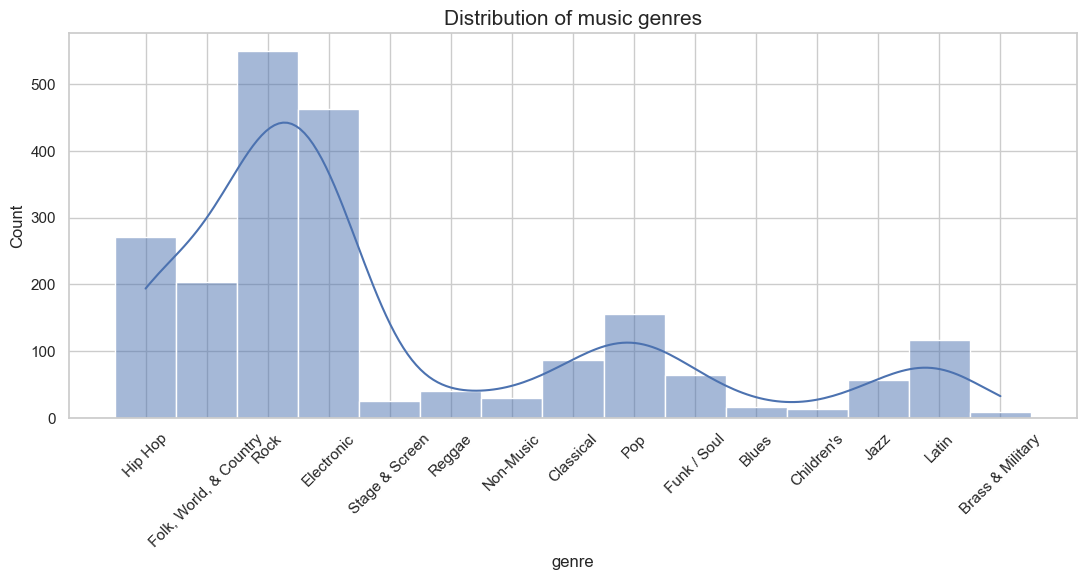

In [9]:
# Plot distribution of music styles with seaborn
plt.figure(figsize=(13, 5))
sns.histplot(df["genre"], kde=True)
plt.xticks(rotation=45)
plt.title("Distribution of music genres", fontsize=15)
plt.show()

In [10]:
query = """
SELECT count(*) as count, genre_style
FROM audio_features
GROUP BY genre_style
ORDER BY count DESC
"""

result = query_df_with_sql(query, df[["filepath", "genre_style"]])
result.rename(columns={"count": "track_count"}).to_csv(
    f"../data/processed/{now_str}_analysis_style_counts.csv", index=False
)

## How fast and danceable is the music? Plot tempo and danceability distribution.

In [11]:
df[["tempocnn_bpm", "effnet_discogs_danceable", "effnet_discogs_not_danceable"]].head(3)

,tempocnn_bpm,effnet_discogs_danceable,effnet_discogs_not_danceable
0,99.0,0.998107,0.001893
1,71.0,0.279656,0.720344
2,155.0,0.052946,0.947054


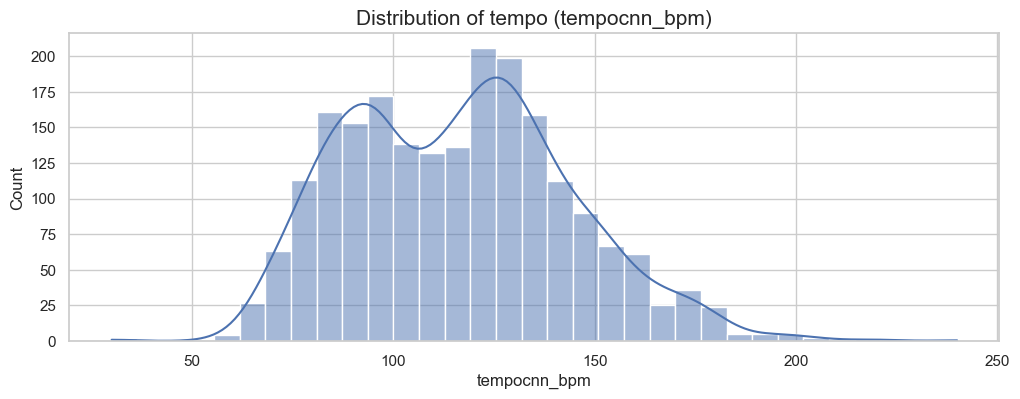

In [12]:
# tempo (tempocnn_bpm)
plt.figure(figsize=(12, 4))
sns.histplot(df["tempocnn_bpm"], kde=True)
plt.title("Distribution of tempo (tempocnn_bpm)", fontsize=15)
plt.show()

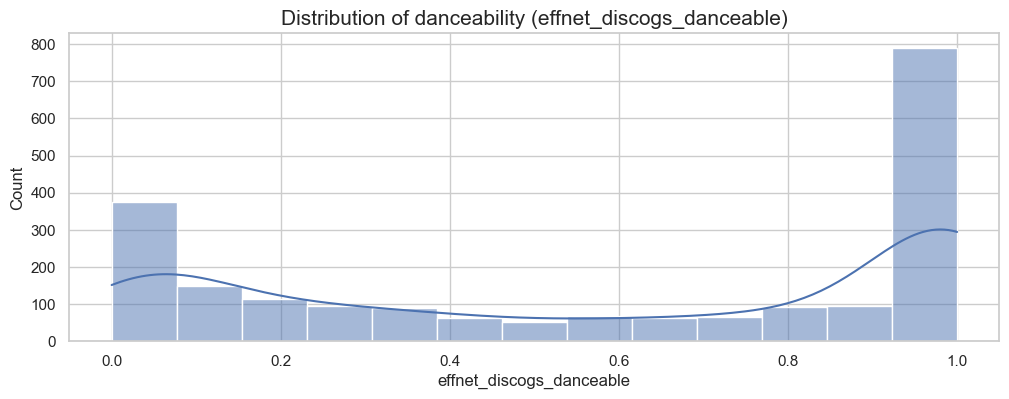

In [13]:
# danceability (effnet_discogs_danceable)
plt.figure(figsize=(12, 4))
sns.histplot(df["effnet_discogs_danceable"], kde=True)
plt.title("Distribution of danceability (effnet_discogs_danceable)", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Distribution of danceability (effnet_discogs_danceable > 0.5)')

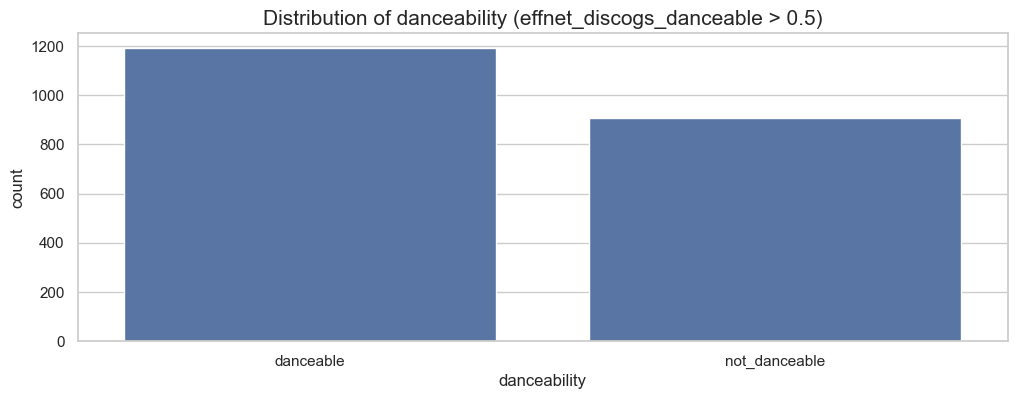

In [14]:
df["danceability"] = df["effnet_discogs_danceable"].apply(
    lambda x: "danceable" if x > 0.5 else "not_danceable"
)
plt.figure(figsize=(12, 4))
sns.countplot(x="danceability", data=df)
plt.title("Distribution of danceability (effnet_discogs_danceable > 0.5)", fontsize=15)

## Which keys/scales are used in the collection? 
Plot distribution according to the three profiles we used.


In [15]:
# 'key_temperley_predict', 'key_temperley_probability',
# 'key_krumhansl_predict', 'key_krumhansl_probability',
# 'key_edma_predict', 'key_edma_probability',

query = """
SELECT count(*) as count, {profile}
FROM audio_features
GROUP BY {profile}
ORDER BY count DESC
"""

temperley_result = query_df_with_sql(
    query.format(profile="key_temperley_predict"),
    df[["filepath", "key_temperley_predict"]],
)
krumhansl_result = query_df_with_sql(
    query.format(profile="key_krumhansl_predict"),
    df[["filepath", "key_krumhansl_predict"]],
)
edma_result = query_df_with_sql(
    query.format(profile="key_edma_predict"), df[["filepath", "key_edma_predict"]]
)

temperley_result.shape, krumhansl_result.shape, edma_result.shape

((24, 2), (24, 2), (24, 2))

In [16]:
from IPython.display import display, HTML

html_str = f"""
<div style="display: flex; justify-content: center;">
    <table>
        <tr>
            <!-- Titles in first row -->
            <th style="text-align:center; padding: 5px;">Temperley</th>
            <th style="text-align:center; padding: 5px;">Krumhansl</th>
            <th style="text-align:center; padding: 5px;">Edma</th>
        </tr>
        <tr>
            <!-- DataFrames in second row -->
            <td style="vertical-align: top; padding: 5px;">{temperley_result.to_html(index=False)}</td>
            <td style="vertical-align: top; padding: 5px;">{krumhansl_result.to_html(index=False)}</td>
            <td style="vertical-align: top; padding: 5px;">{edma_result.to_html(index=False)}</td>
        </tr>
    </table>
</div>
"""

display(HTML(html_str))

# What about loudness? 
Plot integrated loudness LUFS distribution

In [17]:
df["loudness_ebur128_integrated_lufs_truncated"] = df[
    "loudness_ebur128_integrated_lufs"
].round(1)

In [18]:
query = """
SELECT count(*) as count, loudness_ebur128_integrated_lufs_truncated as loudness_lufs_truncated
FROM audio_features
GROUP BY loudness_ebur128_integrated_lufs_truncated
ORDER BY count DESC
"""
query_df_with_sql(
    query, df[["filepath", "loudness_ebur128_integrated_lufs_truncated"]]
).head(10)

,count,loudness_lufs_truncated
0,37,-8.9
1,35,-9.6
2,32,-9.2
3,31,-8.6
4,31,-8.7
5,30,-9.8
6,29,-7.5
7,29,-8.2
8,29,-9.7
9,29,-11.2


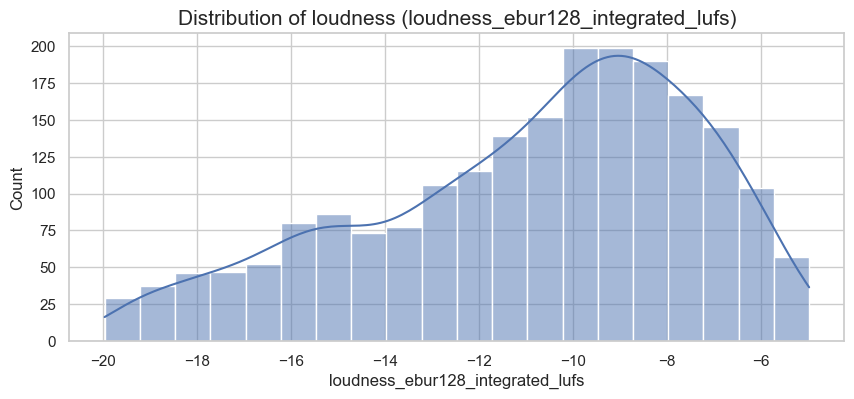

In [19]:
# 'loudness_ebur128_integrated_lufs', 'loudness_ebur128_range_lu'
plt.figure(figsize=(10, 4))
sns.histplot(df["loudness_ebur128_integrated_lufs"], kde=True)
plt.title("Distribution of loudness (loudness_ebur128_integrated_lufs)", fontsize=15)
plt.show()

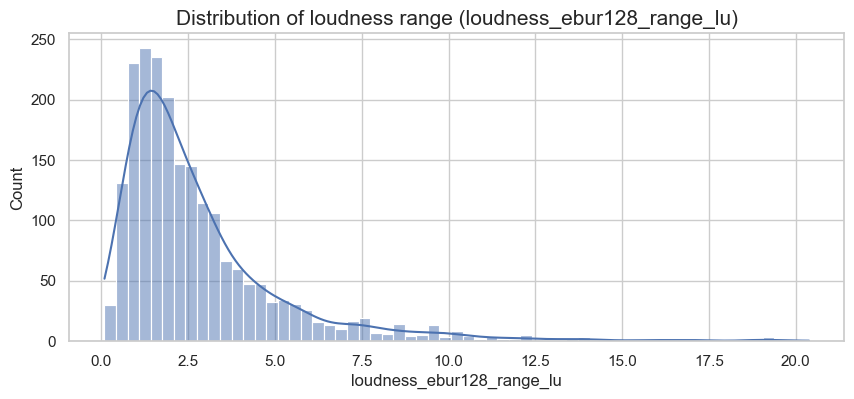

In [20]:
plt.figure(figsize=(10, 4))
sns.histplot(df["loudness_ebur128_range_lu"], kde=True)
plt.title("Distribution of loudness range (loudness_ebur128_range_lu)", fontsize=15)
plt.show()

## How is music represented in terms of arousal/valence emotion space? 
Plot a 2D distribution.

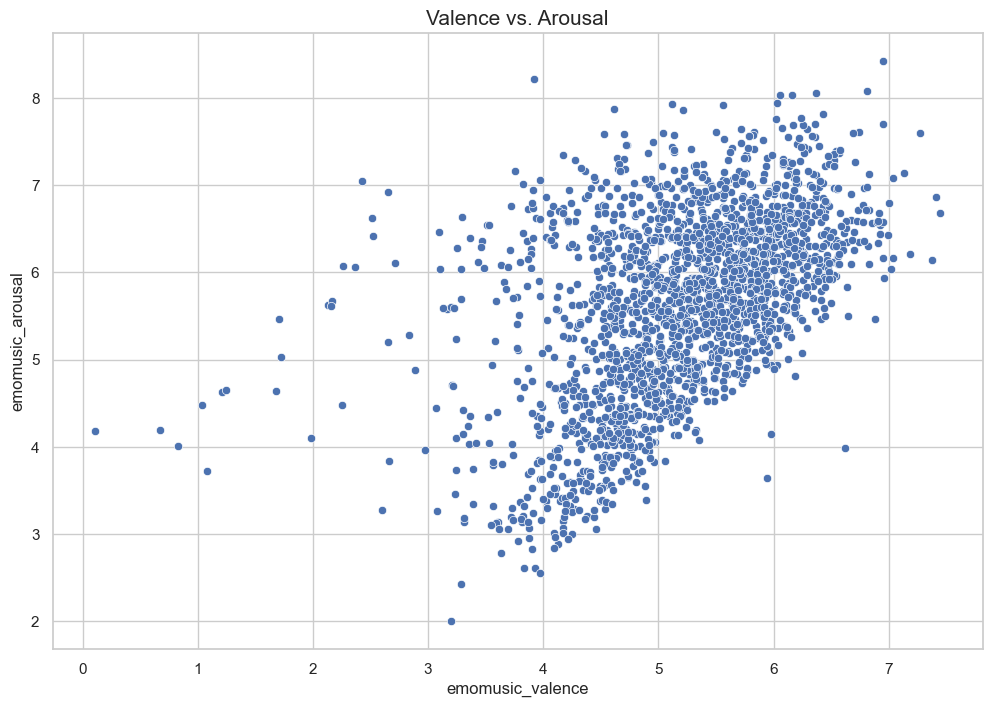

In [21]:
# 'emomusic_valence', 'emomusic_arousal'
plt.figure(figsize=(12, 8))
sns.scatterplot(x="emomusic_valence", y="emomusic_arousal", data=df)
plt.title("Valence vs. Arousal", fontsize=15)
plt.show()

## How much of the music is vocal vs instrumental?

In [22]:
df[["vggish_voice", "vggish_instrumental"]].head(3)

,vggish_voice,vggish_instrumental
0,0.998214,0.001786
1,0.971338,0.028662
2,0.081888,0.918112


In [ ]:
df["instrumental_voice"] = df["vggish_instrumental"].apply(
    lambda x: "instrumental" if x > 0.5 else "voice"
)

In [24]:
df[["vggish_voice", "vggish_instrumental", "instrumental_voice"]].head(3)

,vggish_voice,vggish_instrumental,instrumental_voice
0,0.998214,0.001786,voice
1,0.971338,0.028662,voice
2,0.081888,0.918112,instrumental


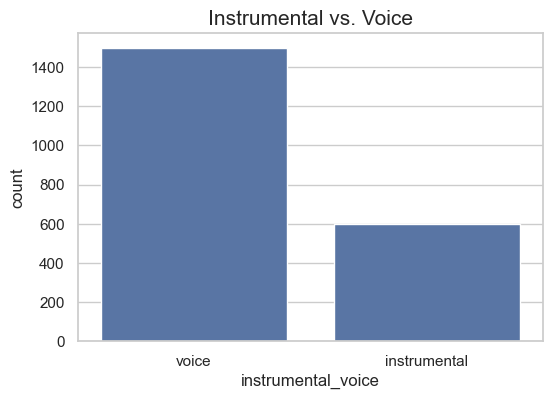

In [25]:
# compare instrumental and voice
plt.figure(figsize=(6, 4))
sns.countplot(x="instrumental_voice", data=df)
plt.title("Instrumental vs. Voice", fontsize=15)
plt.show()